Abel is a computational neuroscientist who runs virtual mouse brain simulations, he wants to update his mesoconnectome, obtained from the original Oh et al 2014 paper, to a laminar-resolved version. The new version of the common coordinate framework (CCF3.0) has segmented the different layers of cortex and can be used as a basis for these predictions. The CCP first downloads the unionized data for the relevant injection sites. CCP further uses the toolkit from Knox et al, to provide and display a volumetric version of these data.  
References:   
Oh, S.W. et al. A mesoscale connectome of the mouse brain. Nature 508, 207–214 (2014). https://doi.org/10.1038/nature13186    
Knox, J.E. et al. High-resolution data-driven model of the mouse connectome. Network Neuroscience 3(1), 217-236 (2018). https://doi.org/10.1162/netn_a_00066  

Initially a series of data structures, files and functions that are utilized throughout the analysis have to be stored in the current directory space.    

The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis, are being downloaded from the storage space and imported as modules.

### Step 1: Data/Parameter Intialization   
Before start of the analysis, an instance of class MesoconnectomePredictor is created (MesoPred) in order to utilize the function for building the layer resolved array.

In [1]:
import os
from subprocess import call
import pickle as pk
from IPython.display import clear_output
current_dir = os.listdir('./')
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is not True and path not in current_dir:
        call(['ln','-s','../25 3 2019/'+ path, path])        
from cfg import *
os.chdir('../CCP_Collab_Backup_2/')
import PrimaryLibrary as PL
imp.reload(PL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import Allen_API_Library as API
imp.reload(API)
MesoPred = PL.MesoconnectomePredictor()

importing Jupyter notebook from Allen_API_Library.ipynb
importing Jupyter notebook from Allen_API_Library.ipynb


In this cell, an initialization of an sbaInterface_class instance is made. The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

In [2]:
# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://sba-dev.incf.org/composer'
sbaUrl  = sbaHost + '/index.php?template=ABA_v3&scene={"background":"FFFFFF"}' 
sbaInterface = PL.sbaInterface_class(sbaHost,sbaUrl)  

### Step 2: Create a layer-resolved connectivity array   
The GetLayerResolvedArray function from MesoPred is being called. This function has two modes with take as input two possible structures, respectively: 
1. unionized for connectivity estimates over anatomically distinct brain areas.
2. voxelized for connectivity estimates over voxels of 100 micrometer cubed.     

This function downloads tract tracing experiments from the Allen Institute for Brain Science and utilizes the mouse connectivity models toolbox developed at the same institute in order to construct a 3D array of type:
1. laminar resolved profiles x source x target brain areas for the unionized mode.
2. laminar resolved profiles x source x target brain voxels for the voxelized mode.

An example of laminar resolved profiles would be L5 PT derived from projections from layer 5 and pyramidal tract specific neuronal populations.

In [3]:
layer_resolved_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'unionized',
                                                                  cre_file = '../25 3 2019/Supplementary Table 1.csv')
#layer_resolved_array = pk.load(open('layer_resolved_array.pkl','rb'))
#model_meta           = pk.load(open('model_meta.pkl','rb'))
clear_output()

### Step 3: Array Visualization    
Let's assume that given the newly created array, Abel wants to visualize projections from MOp (primary motor cortex area).   
Let's further assume that he is interested in layer 6 corticothalamic projections.  
In the above script, such a projection is being selected.

In [4]:
ROI = 'MOp1'
sel_profile = [idx for idx,val in enumerate(model_meta['layer profiles']) if val == 'L6 CT'][0]

In [5]:
selected_source = [idx for idx, val in enumerate(model_meta['source id']) if ROI in val][0]

In this step furthermore, the volume of the selected projection across the mouse brain is being visually inspected with three different approaches:
*  Brain slice visualization with the use of the BrainPlotter tool.
*  3D brain visualization with the use of the Scalable Brain Composer (SBA) tool.
*  Cortical flatmap visualization the use of the BrainPlotter tool.

#### Brain Slice visualization

In [6]:
target_indices = [id2 for val in model_meta['target id'] for id2,val2 in enumerate(MesoPred.targetprofiles['str_acronym']) if val == val2]
source_indices = [id2 for val in model_meta['source id'] for id2,val2 in enumerate(MesoPred.targetprofiles['str_acronym']) if val == val2]

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


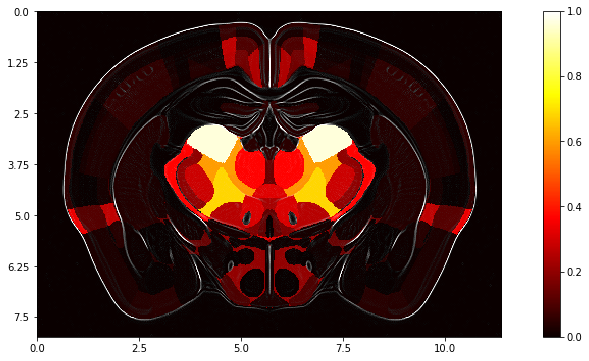

In [7]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = layer_resolved_array[sel_profile,:,selected_source], 
          chosen_indices = target_indices)
BP_25.plot_slice()

#### Call to the SBA tool   
When SBA is being called, a green pop-up window will show up. If the user clicks on "Re-open SBA Composer" the results will be displayed on the window that was opened during the first steps.   
The user can navigate through the various parts of the mouse brain for visual inspection, by utilizing the buttons on the right part of the screen.  
A tutorial for the tool is being provided by clicking at the Readme & FAQ button at the left top of the screen. 

In [8]:
sbaCommand        = BP_25.Call_SBA(InputData = BP_25.pd, mode = 'nifti')
sbaInterface.send(sbaCommand)
clear_output()

#### Cortical flatmap visualization

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


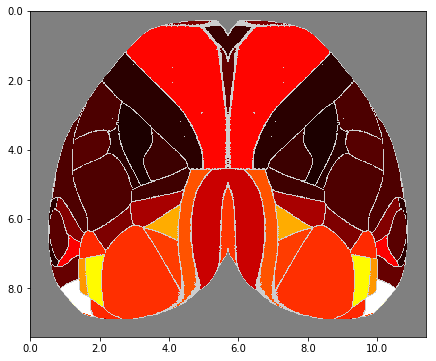

In [9]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = layer_resolved_array[sel_profile,:,selected_source], 
          chosen_indices = target_indices)
BP_10.plot_flatmap()

### Step 4: Export to csv   
Last but not least, the array is being converted in .csv format and uploaded to the storage in case that the user wants to store it in an archive.

In [ ]:
exportFile = 'unionized_layer_specific_matrix.csv'
if os.path.isdir(os.path.join('./', 'csv_results')) == False:
    !mkdir csv_results
for profile_idx, sel_profile in enumerate(model_meta['layer profiles']):
    print 'exporting ' + str(sel_profile) + ' in .csv format'
    if '/' in sel_profile: sel_profile = sel_profile.replace('/','_')
    new_exportFile = exportFile.split('.')[0] + '_'+ sel_profile + '.csv'
    path = os.path.join('csv_results',new_exportFile)
    layer_resolved_df = pd.DataFrame(layer_resolved_array[profile_idx,:,:],\
                                     index = model_meta['target id'],\
                                     columns = model_meta['source id'])
    layer_resolved_df.to_csv(path_or_buf = path)

### Step 5: Volumetric version   
As a last step, the volumetric version can be acquired by using the command below.  
Given the huge dimensionality of the output array, no visualizations will be provided.    
However the data can be exported in .csv format and visualized as shown
in the previous steps.

In [ ]:
layer_resolved_vol_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'voxelized')
clear_output()
print layer_resolved_vol_array.shape

Current analyzed cre lines are: L5 IT -> ['Tlx3-Cre_PL56']


2020-04-01 18:40:48,773 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517314004?image=data_mask&resolution=100
2020-04-01 18:40:49,278 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517314004?image=injection_density&resolution=100
2020-04-01 18:40:49,628 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517314004?image=injection_fraction&resolution=100
2020-04-01 18:40:49,987 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517314004?image=projection_density&resolution=100
2020-04-01 18:40:52,747 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/651041703?image=data_mask&resolution=100
2020-04-01 18:40:53,405 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:41:22,490 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/540146149?image=data_mask&resolution=100
2020-04-01 18:41:23,002 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/540146149?image=injection_density&resolution=100
2020-04-01 18:41:23,355 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/540146149?image=injection_fraction&resolution=100
2020-04-01 18:41:23,707 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/540146149?image=projection_density&resolution=100
2020-04-01 18:41:25,540 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/591223633?image=data_mask&resolution=100
2020-04-01 18:41:26,197 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:41:54,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/555745687?image=data_mask&resolution=100
2020-04-01 18:41:54,716 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/555745687?image=injection_density&resolution=100
2020-04-01 18:41:55,067 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/555745687?image=injection_fraction&resolution=100
2020-04-01 18:41:55,420 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/555745687?image=projection_density&resolution=100
2020-04-01 18:41:56,871 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297593235?image=data_mask&resolution=100
2020-04-01 18:41:57,384 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:42:24,730 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522636747?image=data_mask&resolution=100
2020-04-01 18:42:25,241 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522636747?image=injection_density&resolution=100
2020-04-01 18:42:25,592 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522636747?image=injection_fraction&resolution=100
2020-04-01 18:42:25,942 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522636747?image=projection_density&resolution=100
2020-04-01 18:42:27,580 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/597256577?image=data_mask&resolution=100
2020-04-01 18:42:28,084 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:42:58,459 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/303616833?image=data_mask&resolution=100
2020-04-01 18:42:59,127 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/303616833?image=injection_density&resolution=100
2020-04-01 18:42:59,478 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/303616833?image=injection_fraction&resolution=100
2020-04-01 18:42:59,828 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/303616833?image=projection_density&resolution=100
2020-04-01 18:43:01,718 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288171964?image=data_mask&resolution=100
2020-04-01 18:43:02,227 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:43:29,694 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297593942?image=data_mask&resolution=100
2020-04-01 18:43:30,359 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297593942?image=injection_density&resolution=100
2020-04-01 18:43:30,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297593942?image=injection_fraction&resolution=100
2020-04-01 18:43:31,077 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297593942?image=projection_density&resolution=100
2020-04-01 18:43:32,934 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/502140653?image=data_mask&resolution=100
2020-04-01 18:43:33,587 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:44:06,969 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584902900?image=data_mask&resolution=100
2020-04-01 18:44:07,471 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584902900?image=injection_density&resolution=100
2020-04-01 18:44:07,821 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584902900?image=injection_fraction&resolution=100
2020-04-01 18:44:08,160 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584902900?image=projection_density&resolution=100
2020-04-01 18:44:09,370 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298182842?image=data_mask&resolution=100
2020-04-01 18:44:09,875 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:44:39,755 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/294516943?image=data_mask&resolution=100
2020-04-01 18:44:40,341 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/294516943?image=injection_density&resolution=100
2020-04-01 18:44:40,687 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/294516943?image=injection_fraction&resolution=100
2020-04-01 18:44:41,049 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/294516943?image=projection_density&resolution=100
2020-04-01 18:44:42,387 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/590548119?image=data_mask&resolution=100
2020-04-01 18:44:42,906 allensdk.api.api.retrieve_file_over_http INFO

Current analyzed cre lines are: L2/3 IT -> ['Cux2-IRES-Cre', 'Sepw1-Cre_NP39']


2020-04-01 18:45:05,163 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/520996382?image=data_mask&resolution=100
2020-04-01 18:45:05,663 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/520996382?image=injection_density&resolution=100
2020-04-01 18:45:06,020 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/520996382?image=injection_fraction&resolution=100
2020-04-01 18:45:06,364 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/520996382?image=projection_density&resolution=100
2020-04-01 18:45:08,095 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/272821309?image=data_mask&resolution=100
2020-04-01 18:45:08,751 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:45:36,042 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477834984?image=data_mask&resolution=100
2020-04-01 18:45:36,544 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477834984?image=injection_density&resolution=100
2020-04-01 18:45:36,889 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477834984?image=injection_fraction&resolution=100
2020-04-01 18:45:38,380 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477834984?image=projection_density&resolution=100
2020-04-01 18:45:39,126 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/653191449?image=data_mask&resolution=100
2020-04-01 18:45:39,475 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:46:05,490 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/264076854?image=data_mask&resolution=100
2020-04-01 18:46:06,172 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/264076854?image=injection_density&resolution=100
2020-04-01 18:46:06,535 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/264076854?image=injection_fraction&resolution=100
2020-04-01 18:46:06,879 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/264076854?image=projection_density&resolution=100
2020-04-01 18:46:08,519 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299783689?image=data_mask&resolution=100
2020-04-01 18:46:09,176 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:46:43,463 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/526502209?image=data_mask&resolution=100
2020-04-01 18:46:43,968 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/526502209?image=injection_density&resolution=100
2020-04-01 18:46:44,311 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/526502209?image=injection_fraction&resolution=100
2020-04-01 18:46:44,671 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/526502209?image=projection_density&resolution=100
2020-04-01 18:46:45,906 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477271169?image=data_mask&resolution=100
2020-04-01 18:46:46,409 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:47:12,505 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522773270?image=data_mask&resolution=100
2020-04-01 18:47:13,002 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522773270?image=injection_density&resolution=100
2020-04-01 18:47:13,360 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522773270?image=injection_fraction&resolution=100
2020-04-01 18:47:13,708 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/522773270?image=projection_density&resolution=100
2020-04-01 18:47:15,669 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/263781454?image=data_mask&resolution=100
2020-04-01 18:47:16,170 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:47:40,644 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298830161?image=data_mask&resolution=100
2020-04-01 18:47:41,300 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298830161?image=injection_density&resolution=100
2020-04-01 18:47:41,653 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298830161?image=injection_fraction&resolution=100
2020-04-01 18:47:42,005 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298830161?image=projection_density&resolution=100
2020-04-01 18:47:43,218 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286299886?image=data_mask&resolution=100
2020-04-01 18:47:43,871 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:48:11,251 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182616478?image=data_mask&resolution=100
2020-04-01 18:48:11,907 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182616478?image=injection_density&resolution=100
2020-04-01 18:48:12,267 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182616478?image=injection_fraction&resolution=100
2020-04-01 18:48:12,647 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182616478?image=projection_density&resolution=100
2020-04-01 18:48:14,441 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/477269754?image=data_mask&resolution=100
2020-04-01 18:48:14,945 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:48:41,502 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/506890448?image=data_mask&resolution=100
2020-04-01 18:48:42,004 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/506890448?image=injection_density&resolution=100
2020-04-01 18:48:42,352 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/506890448?image=injection_fraction&resolution=100
2020-04-01 18:48:42,695 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/506890448?image=projection_density&resolution=100
2020-04-01 18:48:44,765 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/294396492?image=data_mask&resolution=100
2020-04-01 18:48:45,418 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:49:12,454 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/552544756?image=data_mask&resolution=100
2020-04-01 18:49:13,108 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/552544756?image=injection_density&resolution=100
2020-04-01 18:49:13,451 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/552544756?image=injection_fraction&resolution=100
2020-04-01 18:49:13,796 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/552544756?image=projection_density&resolution=100
2020-04-01 18:49:15,335 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478780588?image=data_mask&resolution=100
2020-04-01 18:49:15,995 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:49:41,575 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495344543?image=data_mask&resolution=100
2020-04-01 18:49:42,706 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495344543?image=injection_density&resolution=100
2020-04-01 18:49:43,055 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495344543?image=injection_fraction&resolution=100
2020-04-01 18:49:43,411 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495344543?image=projection_density&resolution=100
2020-04-01 18:49:44,613 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/571823196?image=data_mask&resolution=100
2020-04-01 18:49:45,269 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:50:10,763 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/566730846?image=data_mask&resolution=100
2020-04-01 18:50:11,105 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/566730846?image=injection_density&resolution=100
2020-04-01 18:50:11,465 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/566730846?image=injection_fraction&resolution=100
2020-04-01 18:50:11,827 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/566730846?image=projection_density&resolution=100
2020-04-01 18:50:13,302 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182467736?image=data_mask&resolution=100
2020-04-01 18:50:13,961 allensdk.api.api.retrieve_file_over_http INFO

Current analyzed cre lines are: L5 PT -> ['A930038C07Rik-Tg1-Cre', 'Chrna2-Cre_OE25', 'Efr3a-Cre_NO108', 'Sim1-Cre_KJ18']


2020-04-01 18:50:44,463 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/644250774?image=data_mask&resolution=100
2020-04-01 18:50:44,972 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/644250774?image=injection_density&resolution=100
2020-04-01 18:50:45,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/644250774?image=injection_fraction&resolution=100
2020-04-01 18:50:45,680 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/644250774?image=projection_density&resolution=100
2020-04-01 18:50:47,464 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278069982?image=data_mask&resolution=100
2020-04-01 18:50:48,122 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:51:16,440 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172100?image=data_mask&resolution=100
2020-04-01 18:51:16,950 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172100?image=injection_density&resolution=100
2020-04-01 18:51:17,293 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172100?image=injection_fraction&resolution=100
2020-04-01 18:51:17,649 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172100?image=projection_density&resolution=100
2020-04-01 18:51:18,781 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/519486602?image=data_mask&resolution=100
2020-04-01 18:51:19,295 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:51:45,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168164972?image=data_mask&resolution=100
2020-04-01 18:51:45,832 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168164972?image=injection_density&resolution=100
2020-04-01 18:51:46,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168164972?image=injection_fraction&resolution=100
2020-04-01 18:51:46,541 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168164972?image=projection_density&resolution=100
2020-04-01 18:51:48,653 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278258073?image=data_mask&resolution=100
2020-04-01 18:51:49,331 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:52:15,899 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297951732?image=data_mask&resolution=100
2020-04-01 18:52:16,418 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297951732?image=injection_density&resolution=100
2020-04-01 18:52:16,768 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297951732?image=injection_fraction&resolution=100
2020-04-01 18:52:17,111 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297951732?image=projection_density&resolution=100
2020-04-01 18:52:19,239 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/287996596?image=data_mask&resolution=100
2020-04-01 18:52:19,747 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:52:47,490 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297710633?image=data_mask&resolution=100
2020-04-01 18:52:48,157 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297710633?image=injection_density&resolution=100
2020-04-01 18:52:48,509 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297710633?image=injection_fraction&resolution=100
2020-04-01 18:52:48,871 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297710633?image=projection_density&resolution=100
2020-04-01 18:52:50,201 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/176433237?image=data_mask&resolution=100
2020-04-01 18:52:51,193 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:53:17,951 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297985755?image=data_mask&resolution=100
2020-04-01 18:53:18,459 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297985755?image=injection_density&resolution=100
2020-04-01 18:53:18,821 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297985755?image=injection_fraction&resolution=100
2020-04-01 18:53:19,190 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297985755?image=projection_density&resolution=100
2020-04-01 18:53:20,469 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298350212?image=data_mask&resolution=100
2020-04-01 18:53:20,980 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:53:49,870 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286834976?image=data_mask&resolution=100
2020-04-01 18:53:50,384 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286834976?image=injection_density&resolution=100
2020-04-01 18:53:50,733 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286834976?image=injection_fraction&resolution=100
2020-04-01 18:53:51,084 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286834976?image=projection_density&resolution=100
2020-04-01 18:53:52,564 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/281459203?image=data_mask&resolution=100
2020-04-01 18:53:53,233 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:54:20,772 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298324391?image=data_mask&resolution=100
2020-04-01 18:54:21,283 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298324391?image=injection_density&resolution=100
2020-04-01 18:54:21,640 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298324391?image=injection_fraction&resolution=100
2020-04-01 18:54:21,996 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298324391?image=projection_density&resolution=100
2020-04-01 18:54:23,133 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166460484?image=data_mask&resolution=100
2020-04-01 18:54:23,795 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:54:50,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292318449?image=data_mask&resolution=100
2020-04-01 18:54:50,853 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292318449?image=injection_density&resolution=100
2020-04-01 18:54:51,202 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292318449?image=injection_fraction&resolution=100
2020-04-01 18:54:51,562 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292318449?image=projection_density&resolution=100
2020-04-01 18:54:52,858 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/496252297?image=data_mask&resolution=100
2020-04-01 18:54:53,361 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:55:21,011 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292792016?image=data_mask&resolution=100
2020-04-01 18:55:21,524 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292792016?image=injection_density&resolution=100
2020-04-01 18:55:21,874 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292792016?image=injection_fraction&resolution=100
2020-04-01 18:55:22,221 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292792016?image=projection_density&resolution=100
2020-04-01 18:55:23,910 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298325807?image=data_mask&resolution=100
2020-04-01 18:55:24,417 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:55:50,084 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267397941?image=data_mask&resolution=100
2020-04-01 18:55:50,590 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267397941?image=injection_density&resolution=100
2020-04-01 18:55:50,951 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267397941?image=injection_fraction&resolution=100
2020-04-01 18:55:51,306 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267397941?image=projection_density&resolution=100
2020-04-01 18:55:52,792 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298230624?image=data_mask&resolution=100
2020-04-01 18:55:53,308 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:56:19,406 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288168426?image=data_mask&resolution=100
2020-04-01 18:56:19,923 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288168426?image=injection_density&resolution=100
2020-04-01 18:56:20,282 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288168426?image=injection_fraction&resolution=100
2020-04-01 18:56:20,635 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288168426?image=projection_density&resolution=100
2020-04-01 18:56:22,291 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298272589?image=data_mask&resolution=100
2020-04-01 18:56:22,992 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:56:48,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298273313?image=data_mask&resolution=100
2020-04-01 18:56:48,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298273313?image=injection_density&resolution=100
2020-04-01 18:56:49,078 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298273313?image=injection_fraction&resolution=100
2020-04-01 18:56:49,423 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/298273313?image=projection_density&resolution=100
2020-04-01 18:56:51,013 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/287461719?image=data_mask&resolution=100
2020-04-01 18:56:51,517 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:57:20,108 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/642970691?image=data_mask&resolution=100
2020-04-01 18:57:20,655 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/642970691?image=injection_density&resolution=100
2020-04-01 18:57:21,033 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/642970691?image=injection_fraction&resolution=100
2020-04-01 18:57:21,397 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/642970691?image=projection_density&resolution=100
2020-04-01 18:57:22,691 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297714071?image=data_mask&resolution=100
2020-04-01 18:57:23,228 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:57:49,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/602166541?image=data_mask&resolution=100
2020-04-01 18:57:49,885 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/602166541?image=injection_density&resolution=100
2020-04-01 18:57:50,260 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/602166541?image=injection_fraction&resolution=100
2020-04-01 18:57:50,645 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/602166541?image=projection_density&resolution=100
2020-04-01 18:57:51,769 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166461193?image=data_mask&resolution=100
2020-04-01 18:57:52,278 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:58:18,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172846?image=data_mask&resolution=100
2020-04-01 18:58:18,648 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172846?image=injection_density&resolution=100
2020-04-01 18:58:18,998 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172846?image=injection_fraction&resolution=100
2020-04-01 18:58:19,347 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292172846?image=projection_density&resolution=100
2020-04-01 18:58:20,933 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/534175823?image=data_mask&resolution=100
2020-04-01 18:58:21,439 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:58:46,129 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267749107?image=data_mask&resolution=100
2020-04-01 18:58:46,792 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267749107?image=injection_density&resolution=100
2020-04-01 18:58:47,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267749107?image=injection_fraction&resolution=100
2020-04-01 18:58:47,504 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267749107?image=projection_density&resolution=100
2020-04-01 18:58:48,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166325321?image=data_mask&resolution=100
2020-04-01 18:58:49,270 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:59:15,545 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/301179679?image=data_mask&resolution=100
2020-04-01 18:59:16,056 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/301179679?image=injection_density&resolution=100
2020-04-01 18:59:16,413 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/301179679?image=injection_fraction&resolution=100
2020-04-01 18:59:16,761 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/301179679?image=projection_density&resolution=100


Current analyzed cre lines are: L4/5 IT -> ['Scnn1a-Tg3-Cre', 'Rorb-IRES2-Cre']


2020-04-01 18:59:23,027 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159888336?image=data_mask&resolution=100
2020-04-01 18:59:23,548 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159888336?image=injection_density&resolution=100
2020-04-01 18:59:23,915 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159888336?image=injection_fraction&resolution=100
2020-04-01 18:59:24,269 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159888336?image=projection_density&resolution=100
2020-04-01 18:59:26,814 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166458363?image=data_mask&resolution=100
2020-04-01 18:59:27,314 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 18:59:53,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166459070?image=data_mask&resolution=100
2020-04-01 18:59:54,224 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166459070?image=injection_density&resolution=100
2020-04-01 18:59:54,580 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166459070?image=injection_fraction&resolution=100
2020-04-01 18:59:54,942 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166459070?image=projection_density&resolution=100
2020-04-01 18:59:56,468 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/268038262?image=data_mask&resolution=100
2020-04-01 18:59:57,135 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:00:23,444 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/268038969?image=data_mask&resolution=100
2020-04-01 19:00:23,966 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/268038969?image=injection_density&resolution=100
2020-04-01 19:00:24,317 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/268038969?image=injection_fraction&resolution=100
2020-04-01 19:00:24,673 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/268038969?image=projection_density&resolution=100
2020-04-01 19:00:26,078 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/300929973?image=data_mask&resolution=100
2020-04-01 19:00:26,592 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:00:53,949 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/184075100?image=data_mask&resolution=100
2020-04-01 19:00:54,466 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/184075100?image=injection_density&resolution=100
2020-04-01 19:00:54,818 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/184075100?image=injection_fraction&resolution=100
2020-04-01 19:00:55,165 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/184075100?image=projection_density&resolution=100
2020-04-01 19:00:56,524 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/301618122?image=data_mask&resolution=100
2020-04-01 19:00:57,196 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:01:23,352 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267101850?image=data_mask&resolution=100
2020-04-01 19:01:23,867 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267101850?image=injection_density&resolution=100
2020-04-01 19:01:24,227 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267101850?image=injection_fraction&resolution=100
2020-04-01 19:01:24,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/267101850?image=projection_density&resolution=100
2020-04-01 19:01:25,712 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181860173?image=data_mask&resolution=100
2020-04-01 19:01:26,218 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:01:51,973 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278502708?image=data_mask&resolution=100
2020-04-01 19:01:52,512 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278502708?image=injection_density&resolution=100
2020-04-01 19:01:52,939 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278502708?image=injection_fraction&resolution=100
2020-04-01 19:01:53,362 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/278502708?image=projection_density&resolution=100
2020-04-01 19:01:54,751 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/287880102?image=data_mask&resolution=100
2020-04-01 19:01:55,293 allensdk.api.api.retrieve_file_over_http INFO

Current analyzed cre lines are: L6 CT -> ['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']


2020-04-01 19:02:10,821 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=data_mask&resolution=100
2020-04-01 19:02:11,332 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=injection_density&resolution=100
2020-04-01 19:02:11,689 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=injection_fraction&resolution=100
2020-04-01 19:02:12,045 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=projection_density&resolution=100
2020-04-01 19:02:14,214 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292791310?image=data_mask&resolution=100
2020-04-01 19:02:14,720 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:02:40,501 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159322514?image=data_mask&resolution=100
2020-04-01 19:02:41,020 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159322514?image=injection_density&resolution=100
2020-04-01 19:02:41,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159322514?image=injection_fraction&resolution=100
2020-04-01 19:02:41,726 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159322514?image=projection_density&resolution=100
2020-04-01 19:02:43,151 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159223769?image=data_mask&resolution=100
2020-04-01 19:02:43,666 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:03:08,527 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159554010?image=data_mask&resolution=100
2020-04-01 19:03:09,027 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159554010?image=injection_density&resolution=100
2020-04-01 19:03:09,383 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159554010?image=injection_fraction&resolution=100
2020-04-01 19:03:09,750 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159554010?image=projection_density&resolution=100
2020-04-01 19:03:11,214 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266412788?image=data_mask&resolution=100
2020-04-01 19:03:11,882 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:03:36,034 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478257959?image=data_mask&resolution=100
2020-04-01 19:03:36,543 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478257959?image=injection_density&resolution=100
2020-04-01 19:03:36,900 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478257959?image=injection_fraction&resolution=100
2020-04-01 19:03:37,262 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478257959?image=projection_density&resolution=100
2020-04-01 19:03:38,589 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/157769139?image=data_mask&resolution=100
2020-04-01 19:03:39,101 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:04:04,748 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539739321?image=data_mask&resolution=100
2020-04-01 19:04:05,265 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539739321?image=injection_density&resolution=100
2020-04-01 19:04:05,619 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539739321?image=injection_fraction&resolution=100
2020-04-01 19:04:05,962 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539739321?image=projection_density&resolution=100
2020-04-01 19:04:07,581 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/177319236?image=data_mask&resolution=100
2020-04-01 19:04:08,092 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:04:32,285 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158141324?image=data_mask&resolution=100
2020-04-01 19:04:32,808 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158141324?image=injection_density&resolution=100
2020-04-01 19:04:33,175 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158141324?image=injection_fraction&resolution=100
2020-04-01 19:04:33,547 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158141324?image=projection_density&resolution=100
2020-04-01 19:04:34,797 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159551564?image=data_mask&resolution=100
2020-04-01 19:04:35,469 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:05:01,252 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517974408?image=data_mask&resolution=100
2020-04-01 19:05:01,782 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517974408?image=injection_density&resolution=100
2020-04-01 19:05:02,148 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517974408?image=injection_fraction&resolution=100
2020-04-01 19:05:02,501 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/517974408?image=projection_density&resolution=100
2020-04-01 19:05:04,016 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/603890605?image=data_mask&resolution=100
2020-04-01 19:05:04,522 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:05:30,403 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/557341233?image=data_mask&resolution=100
2020-04-01 19:05:30,919 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/557341233?image=injection_density&resolution=100
2020-04-01 19:05:31,271 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/557341233?image=injection_fraction&resolution=100
2020-04-01 19:05:31,684 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/557341233?image=projection_density&resolution=100
2020-04-01 19:05:33,224 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/265820216?image=data_mask&resolution=100
2020-04-01 19:05:33,759 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:06:01,550 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159750477?image=data_mask&resolution=100
2020-04-01 19:06:02,076 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159750477?image=injection_density&resolution=100
2020-04-01 19:06:02,424 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159750477?image=injection_fraction&resolution=100
2020-04-01 19:06:02,774 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159750477?image=projection_density&resolution=100
2020-04-01 19:06:04,315 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159224478?image=data_mask&resolution=100
2020-04-01 19:06:04,689 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:06:31,976 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488964?image=data_mask&resolution=100
2020-04-01 19:06:32,483 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488964?image=injection_density&resolution=100
2020-04-01 19:06:32,835 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488964?image=injection_fraction&resolution=100
2020-04-01 19:06:33,187 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488964?image=projection_density&resolution=100
2020-04-01 19:06:34,190 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/514332492?image=data_mask&resolution=100
2020-04-01 19:06:34,541 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:06:59,841 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181258571?image=data_mask&resolution=100
2020-04-01 19:07:00,360 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181258571?image=injection_density&resolution=100
2020-04-01 19:07:00,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181258571?image=injection_fraction&resolution=100
2020-04-01 19:07:01,069 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181258571?image=projection_density&resolution=100
2020-04-01 19:07:02,109 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/304641170?image=data_mask&resolution=100
2020-04-01 19:07:02,625 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:07:28,890 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/177783204?image=data_mask&resolution=100
2020-04-01 19:07:29,399 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/177783204?image=injection_density&resolution=100
2020-04-01 19:07:29,750 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/177783204?image=injection_fraction&resolution=100
2020-04-01 19:07:30,102 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/177783204?image=projection_density&resolution=100
2020-04-01 19:07:31,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168363168?image=data_mask&resolution=100
2020-04-01 19:07:32,377 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:07:58,419 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159511623?image=data_mask&resolution=100
2020-04-01 19:07:58,934 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159511623?image=injection_density&resolution=100
2020-04-01 19:07:59,283 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159511623?image=injection_fraction&resolution=100
2020-04-01 19:07:59,651 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159511623?image=projection_density&resolution=100
2020-04-01 19:08:00,962 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/514313871?image=data_mask&resolution=100
2020-04-01 19:08:01,464 allensdk.api.api.retrieve_file_over_http INFO

Current analyzed cre lines are: layer inspecific -> ['C57BL/6J', 'Emx1-IRES-Cre']


2020-04-01 19:08:17,998 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/500836840?image=data_mask&resolution=100
2020-04-01 19:08:18,505 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/500836840?image=injection_density&resolution=100
2020-04-01 19:08:18,865 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/500836840?image=injection_fraction&resolution=100
2020-04-01 19:08:19,213 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/500836840?image=projection_density&resolution=100
2020-04-01 19:08:21,691 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584194481?image=data_mask&resolution=100
2020-04-01 19:08:22,195 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:08:58,848 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/502966396?image=data_mask&resolution=100
2020-04-01 19:08:59,380 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/502966396?image=injection_density&resolution=100
2020-04-01 19:08:59,733 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/502966396?image=injection_fraction&resolution=100
2020-04-01 19:09:00,095 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/502966396?image=projection_density&resolution=100
2020-04-01 19:09:01,577 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518742338?image=data_mask&resolution=100
2020-04-01 19:09:01,960 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:09:36,220 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/583747816?image=data_mask&resolution=100
2020-04-01 19:09:36,732 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/583747816?image=injection_density&resolution=100
2020-04-01 19:09:37,085 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/583747816?image=injection_fraction&resolution=100
2020-04-01 19:09:37,444 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/583747816?image=projection_density&resolution=100
2020-04-01 19:09:40,972 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/584895127?image=data_mask&resolution=100
2020-04-01 19:09:41,512 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:10:12,733 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518605900?image=data_mask&resolution=100
2020-04-01 19:10:13,088 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518605900?image=injection_density&resolution=100
2020-04-01 19:10:13,436 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518605900?image=injection_fraction&resolution=100
2020-04-01 19:10:13,780 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518605900?image=projection_density&resolution=100
2020-04-01 19:10:16,003 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/583748537?image=data_mask&resolution=100
2020-04-01 19:10:16,530 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:10:53,477 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/501115762?image=data_mask&resolution=100
2020-04-01 19:10:54,036 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/501115762?image=injection_density&resolution=100
2020-04-01 19:10:54,396 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/501115762?image=injection_fraction&resolution=100
2020-04-01 19:10:54,773 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/501115762?image=projection_density&resolution=100
2020-04-01 19:10:56,180 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/536299435?image=data_mask&resolution=100
2020-04-01 19:10:56,695 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:11:30,365 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478582494?image=data_mask&resolution=100
2020-04-01 19:11:30,872 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478582494?image=injection_density&resolution=100
2020-04-01 19:11:31,241 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478582494?image=injection_fraction&resolution=100
2020-04-01 19:11:31,603 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478582494?image=projection_density&resolution=100
2020-04-01 19:11:34,460 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/479673887?image=data_mask&resolution=100
2020-04-01 19:11:34,979 allensdk.api.api.retrieve_file_over_http INFO

Current analyzed cre lines are: L4 IT -> ['Nr5a1-Cre']


2020-04-01 19:12:13,008 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/277851379?image=data_mask&resolution=100
2020-04-01 19:12:13,516 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/277851379?image=injection_density&resolution=100
2020-04-01 19:12:13,872 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/277851379?image=injection_fraction&resolution=100
2020-04-01 19:12:14,224 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/277851379?image=projection_density&resolution=100
2020-04-01 19:12:17,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166566678?image=data_mask&resolution=100
2020-04-01 19:12:17,949 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:12:44,404 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/293548317?image=data_mask&resolution=100
2020-04-01 19:12:44,914 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/293548317?image=injection_density&resolution=100
2020-04-01 19:12:45,274 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/293548317?image=injection_fraction&resolution=100
2020-04-01 19:12:45,629 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/293548317?image=projection_density&resolution=100
2020-04-01 19:12:46,795 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266177248?image=data_mask&resolution=100
2020-04-01 19:12:47,325 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:13:12,708 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266175461?image=data_mask&resolution=100
2020-04-01 19:13:13,212 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266175461?image=injection_density&resolution=100
2020-04-01 19:13:13,565 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266175461?image=injection_fraction&resolution=100
2020-04-01 19:13:13,925 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266175461?image=projection_density&resolution=100


Current analyzed cre lines are: L5 IT PT CT -> ['Rbp4-Cre_KL100']


2020-04-01 19:13:18,698 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/249402048?image=data_mask&resolution=100
2020-04-01 19:13:19,209 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/249402048?image=injection_density&resolution=100
2020-04-01 19:13:19,558 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/249402048?image=injection_fraction&resolution=100
2020-04-01 19:13:19,923 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/249402048?image=projection_density&resolution=100
2020-04-01 19:13:23,404 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/523718823?image=data_mask&resolution=100
2020-04-01 19:13:24,065 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:13:59,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266249483?image=data_mask&resolution=100
2020-04-01 19:14:00,008 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266249483?image=injection_density&resolution=100
2020-04-01 19:14:00,372 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266249483?image=injection_fraction&resolution=100
2020-04-01 19:14:00,753 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/266249483?image=projection_density&resolution=100
2020-04-01 19:14:03,296 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166055636?image=data_mask&resolution=100
2020-04-01 19:14:03,809 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:14:40,453 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/530574594?image=data_mask&resolution=100
2020-04-01 19:14:40,970 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/530574594?image=injection_density&resolution=100
2020-04-01 19:14:41,364 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/530574594?image=injection_fraction&resolution=100
2020-04-01 19:14:41,724 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/530574594?image=projection_density&resolution=100
2020-04-01 19:14:43,412 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/530555292?image=data_mask&resolution=100
2020-04-01 19:14:43,926 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:15:16,297 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/503809372?image=data_mask&resolution=100
2020-04-01 19:15:16,840 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/503809372?image=injection_density&resolution=100
2020-04-01 19:15:17,203 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/503809372?image=injection_fraction&resolution=100
2020-04-01 19:15:17,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/503809372?image=projection_density&resolution=100
2020-04-01 19:15:19,636 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182793477?image=data_mask&resolution=100
2020-04-01 19:15:20,307 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:15:54,871 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/272698650?image=data_mask&resolution=100
2020-04-01 19:15:55,409 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/272698650?image=injection_density&resolution=100
2020-04-01 19:15:55,793 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/272698650?image=injection_fraction&resolution=100
2020-04-01 19:15:56,157 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/272698650?image=projection_density&resolution=100
2020-04-01 19:15:58,756 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/524667618?image=data_mask&resolution=100
2020-04-01 19:15:59,422 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:16:33,700 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166054929?image=data_mask&resolution=100
2020-04-01 19:16:34,214 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166054929?image=injection_density&resolution=100
2020-04-01 19:16:34,557 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166054929?image=injection_fraction&resolution=100
2020-04-01 19:16:34,933 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/166054929?image=projection_density&resolution=100
2020-04-01 19:16:37,112 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/566992832?image=data_mask&resolution=100
2020-04-01 19:16:37,639 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:17:10,624 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286417464?image=data_mask&resolution=100
2020-04-01 19:17:11,136 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286417464?image=injection_density&resolution=100
2020-04-01 19:17:11,480 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286417464?image=injection_fraction&resolution=100
2020-04-01 19:17:11,835 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286417464?image=projection_density&resolution=100
2020-04-01 19:17:13,200 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297652799?image=data_mask&resolution=100
2020-04-01 19:17:13,549 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:17:47,611 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286312782?image=data_mask&resolution=100
2020-04-01 19:17:48,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286312782?image=injection_density&resolution=100
2020-04-01 19:17:48,492 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286312782?image=injection_fraction&resolution=100
2020-04-01 19:17:48,844 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/286312782?image=projection_density&resolution=100
2020-04-01 19:17:51,094 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/161458737?image=data_mask&resolution=100
2020-04-01 19:17:51,603 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:18:26,505 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/510417255?image=data_mask&resolution=100
2020-04-01 19:18:27,017 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/510417255?image=injection_density&resolution=100
2020-04-01 19:18:27,369 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/510417255?image=injection_fraction&resolution=100
2020-04-01 19:18:27,733 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/510417255?image=projection_density&resolution=100
2020-04-01 19:18:29,194 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/593277684?image=data_mask&resolution=100
2020-04-01 19:18:29,734 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 19:19:03,932 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/183173527?image=data_mask&resolution=100
2020-04-01 19:19:04,448 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/183173527?image=injection_density&resolution=100
2020-04-01 19:19:04,798 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/183173527?image=injection_fraction&resolution=100
2020-04-01 19:19:05,160 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/183173527?image=projection_density&resolution=100
2020-04-01 19:19:06,922 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/656632388?image=data_mask&resolution=100
2020-04-01 19:19:07,278 allensdk.api.api.retrieve_file_over_http INFO

In [ ]:
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is True:
        #call(['ln','-s','../25 3 2019/'+ path, path])
        os.unlink(path)